## Import & Start engines
Install all important libraries with pip apart from `matlab.engine` which has to be installed from the MATLAB root folder. You can find more information on instlaling the `matlab.engine` [here](https://de.mathworks.com/help/matlab/matlab_external/install-the-matlab-engine-for-python.html)

In [98]:
import matlab.engine
import numpy as np
from cProfile import label
import matplotlib.pyplot as plt
%matplotlib widget
import pathlib
from ecgdetectors import Detectors
import sys
import wfdb
from wfdb import processing

Start the `matlab.engine` to be able to execute MATLAB commands or functions from within Python.

In [86]:
eng = matlab.engine.start_matlab()

## Class Definition
The necessary classes for the detectors and the databases are created.

In [87]:
class Detector():
    def __init__(self, name, algorithm):
        self.name = name
        self.algorithm = algorithm
    
    def predicted_qrs_compelx(self, signal, fs):
        return self.algorithm(signal, fs)

    def name(self):
        return self.name

class Database():
    def __init__(self, name, signal, actual_qrs_complex, fs):
        self.name = name
        self.signal = signal
        self.actual_qrs_complex = actual_qrs_complex
        self.fs = fs
    
    def signal(self):
        return self.signal

    def actual_qrs_complex(self):
        return self.actual_qrs_complex

    def fs(self):
        return self.fs

Create arrays to safe the detectors and databases.

In [88]:
detectors = []
databases = []

## Synthetic signal generator
Some initial parameters for the generation of the synthetic signals. Here it is possible to choose diffent types of artificial noise and also choose whether the signal should be real or synthetic.

In [89]:
# ---Initial parameters---
rrLength = 50       # A desired ECG signal length (the number of RR intervals) 
APBrate = 0.10      # Rate of atrial premature beats (APB). A number between 0 and 0.5
onlyRR = 0          # 1 - only RR intervals are generated, 0 - multilead ECG is generated

medEpis = 15        # Median duration of an atrial fibrillation (AF) episode
stayInAF = float(1-np.log(2)/medEpis)   # Probability to stay in AF state
AFburden = 0.8      # AF burden. 0 - the entire signal is sinus rhythm (SR), 1 - the entire signal is AF

noiseType = 4       # Type of noise. A number from 0 to 4. 0 - no noise added (noise RMS = 0 mV), 
                    # 1 - motion artefacts, 2 - electrode movement artefacts, 3 - baseline wander, 
                    # 4 - mixture of type 1, type 2 and type 3 noises
noiseRMS = 0.02     # Noise level in milivolts 

realRRon = 1       # 1 - real RR series are used, 0 - synthetic
realVAon = 1       # 1 - real ventricular activity is used, 0 - synthetic
realAAon = 1       # 1 - real atrial activity is used, 0 - synthetic
# Note: cannot select real atrial activity and synthetic ventricular activity

In the next field the signal is generated.

In [90]:
signal_generator_path = eng.genpath('C:/Users/flori\OneDrive\Dokumente\TU\Bachelor Thesis\Code\Signal_generator')
eng.addpath(signal_generator_path, nargout=0)

returndata = eng.simPAF_ECG_generator(rrLength, realRRon, realVAon, realAAon, AFburden, stayInAF, APBrate, noiseType, noiseRMS, onlyRR)

Add signal to database.

In [91]:
actualpeaks = np.transpose(np.array(returndata['QRSindex']))[:,0].astype(int)

In [92]:
databases.append(Database(
    name="Synthetic data", 
    signal=np.transpose(np.array(returndata['multileadECG']))[:,0], 
    actual_qrs_complex=np.transpose(np.array(returndata['QRSindex']))[:,0].astype(int), 
    fs=500))

In [93]:
detectors.append(Detector(name="GQRS", algorithm=processing.qrs.gqrs_detect))

In [100]:
def run_two_average_detector(signal, fs):
    return Detectors(fs).two_average_detector(unfiltered_ecg=signal)

def run_matched_filter_detector(signal, fs):
        return Detectors(fs).matched_filter_detector(unfiltered_ecg=signal)

def run_swt_detector(signal, fs):
    return Detectors(fs).swt_detector(unfiltered_ecg=signal)

def run_engzee_detector(signal, fs):
    return Detectors(fs).engzee_detector(unfiltered_ecg=signal)

def run_christov_detector(signal, fs):
    return Detectors(fs).christov_detector(unfiltered_ecg=signal)

def run_hamilton_detector(signal, fs):
    return Detectors(fs).hamilton_detector(unfiltered_ecg=signal)

def run_pan_tompkins_detector(signal, fs):
    return Detectors(fs).pan_tompkins_detector(unfiltered_ecg=signal)

def run_wqrs_detector(signal, fs):
    return Detectors(fs).wqrs_detector(unfiltered_ecg=signal)

In [101]:
detectors.append(Detector(name="Elgendi et al (Two average)", algorithm=run_two_average_detector))
detectors.append(Detector(name="Matched filter", algorithm=run_matched_filter_detector))
detectors.append(Detector(name="Kalidas & Tamil (Wavelet transform)", algorithm=run_swt_detector))
detectors.append(Detector(name="Engzee", algorithm=run_engzee_detector))
detectors.append(Detector(name="Christov", algorithm=run_christov_detector))
detectors.append(Detector(name="Hamilton", algorithm=run_hamilton_detector))
detectors.append(Detector(name="Pan Tompkins", algorithm=run_pan_tompkins_detector))
detectors.append(Detector(name="WQRS", algorithm=run_wqrs_detector))

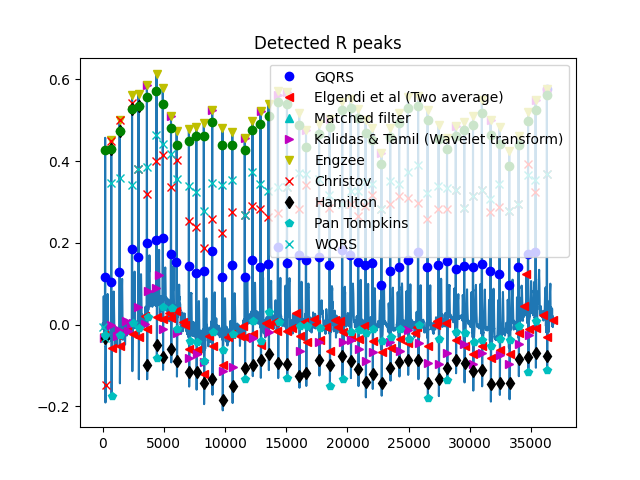

In [109]:
predictedpeaks = []
labels = []
for i in range(len(detectors)):
    if i==2:
        predictedpeaks.append([])
        labels.append(detectors[i].name)
        continue
    predictedpeaks.append(detectors[i].predicted_qrs_compelx(signal=databases[0].signal, fs=databases[0].fs))
    labels.append(detectors[i].name)

fmt = ['bo','r<','c^','m>','yv','rx','kd','cp','cx','b>']


plt.figure()
plt.plot(databases[0].signal)
for i in range(len(predictedpeaks)):
    plt.plot(predictedpeaks[i], databases[0].signal[predictedpeaks[i]], fmt[i],label=detectors[i].name)
plt.plot(databases[0].actual_qrs_complex, databases[0].signal[databases[0].actual_qrs_complex], 'go')
plt.title("Detected R peaks")
plt.legend()

plt.show()

In [110]:
numalgorithms = len(predictedpeaks)

tp = np.zeros(numalgorithms, dtype=int)
fp = np.zeros(numalgorithms, dtype=int)
fn = np.zeros(numalgorithms, dtype=int)

for j in range(len(predictedpeaks)):

    actualpeaksiter = actualpeaks

    for predictedpeak in predictedpeaks[j]:
        tpdetect = 1
        for i in range(len(actualpeaksiter)):
            if predictedpeak >= (actualpeaksiter[i] - 150) and predictedpeak <= (actualpeaksiter[i] + 150):
                tp[j]+=1
                tpdetect = 0
                actualpeaksiter = np.delete(actualpeaksiter, i)
                break
        if tpdetect:
            fp[j]+=1

    for actualpeak in actualpeaksiter:
        fn[j]+=1

print("actual peaks = ", len(actualpeaks))
print("predicted peaks = ", [len(predictedpeaksperalg) for predictedpeaksperalg in predictedpeaks])
print("true positive = ", tp)
print("false positive = ", fp)
print("false negative = ", fn)

actual peaks =  50
predicted peaks =  [50, 77, 0, 57, 49, 51, 50, 50, 51]
true positive =  [50 50  0 50 49 50 50 50 50]
false positive =  [ 0 27  0  7  0  1  0  0  1]
false negative =  [ 0  0 50  0  1  0  0  0  0]


In [111]:
sensitivity = tp / (tp+fn)
print("sensitivity = ", np.around(sensitivity,decimals=2))

positive_predictivity = tp / (tp+fp)
print("positive predictivity = ", np.around(positive_predictivity,decimals=2))

f1_score = tp / (tp+.5*(fp+fn))
print("f1 score = ", np.around(f1_score,decimals=2))

sensitivity =  [1.   1.   0.   1.   0.98 1.   1.   1.   1.  ]
positive predictivity =  [1.   0.65  nan 0.88 1.   0.98 1.   1.   0.98]
f1 score =  [1.   0.79 0.   0.93 0.99 0.99 1.   1.   0.99]


C:\Users\flori\AppData\Local\Temp\ipykernel_40484\1440835149.py:4: RuntimeWarning: invalid value encountered in divide
  positive_predictivity = tp / (tp+fp)
